### Definicja Problemu

Dla danego obrazu celem jest znalezienie ciągu $M$ trójkątów o dowolnych kolorach, które po nałożeniu na puste płótno jak najlepiej dopasują się do wejściowego obrazu. Każdy trójkąt ma taki sam współczynnik przezroczystości $\alpha$, który jest parameterem problemu.

$$
\Omega = ((\mathbb{Z} \times \mathbb{Z})^3 \times \{0,1,\dots,255 \}^3)^M
$$

$$
F(\text{triangles}) = \sum_{x=0}^{W-1} \sum_{y=0}^{H-1} \sum_{c \in \{R, G, B\}} \left( I_\text{target}
(x, y, c) - I_\text{painted}(x, y, c; \text{triangles}, \alpha) \right)^2
$$

### Opis Algorytmu 

Algorytm rozwiązuje problem, iteracyjnie zwiększając liczbę trójkątów w rozwiązaniu. Do ustawienia 
nowego trójkąta stosowana jest standardowa strategia ewolucyjna $(\mu + \lambda)$, wykorzystująca jedynie
operatory mutacji. Każda mutacja losowo wybiera trójkąt do modyfikacji, faworyzując
trójkąty, które będą nakładane na końcu. W szczególności ostatni trójkąt jest wyróżniony i ma
$\frac{2}{3}$ szansy na zostanie wybranym.

Podstawową mutacją jest wygenerowanie nowego trójkąta, którego pozycja ustalana jest na podstawie
heurystyki wyliczającej piksele, w otoczeniu których jest potencjał na poprawę. Wierzchołki trójkąta są
wybierane jako pewne zaburzenie względem wybranego piksela. Na początku wartość zaburzenia jest
dosyć duża by zapewnić szerokie przeszukiwanie, lecz od pewnego momentu ta wartość maleje, w celu
uniknięcia kosztownego analizowania dużych losowych trójkątów.
Jeśli wtedy opłacalne jest postawienie dużego trójkąta, algorytm najpierw ustawi mały trójkąt,
który się w nim zawiera, a następnie go rozszerzy.

Kolejną mutacją jest przesunięcie jednego z wierzchołków w losowym kierunku. Długość przesunięcia może
być albo "mała", w celu poprawy jakości szczegółów, albo "średnia", by umożliwić szersze przeszukiwanie.
Dokładna wartość tych wielkości zależy od etapu w ewolucji.

Ostatnią mutacją, która jest również wykorzystywana przez poprzednie, jest ustawienie koloru trójkąta.
Pierwsza strategia polega na dodaniu małego zaburzenia do obecnego koloru.
Druga strategia losuje próbkę pikseli w danym trójkącie i ustawia kolor jako małe zaburzenie
średniego koloru wylosowanych punktów.



### Implementacja

Kluczową optymalizacją jest wydajne obliczanie funkcji celu dla zmodyfikowanych dzieci. Korzystając z
wartości dopasowania rodzica, wystarczy obliczyć dopasowanie w prostokącie obejmującym starą
i nową wersję zmodyfikowanego trójkąta. Jest to istotna optymalizacja, ponieważ większość trójkątów jest
bardzo mała.

Algorytm oferuje równoległość obliczeń na poziomie tworzenia potomstwa poprzez użycie wielu wątków
lub procesów. Wielowątkowość okazała się nieskuteczna dla większej liczby trójkątów, ponieważ może być
stosowana jedynie w obliczeniach numerycznych, które są przeplatane iteracjami po trójkątach.
Iteracje te zakładają globalny zamek GIL, przez co koszt zmiany kontekstu przewyższa zaoszczędzony
czas. Z kolei, użycie procesów przynosi znaczącą poprawę wydajności programu.

Heurystyka wyznaczania pikseli, w otoczeniu których istnieje potencjał na poprawę, jest obliczana tylko w
momentach zwiększenia liczby trójkątów. W tym procesie uwzględniany jest jedynie obraz namalowany
przez najlepszego osobnika. Zwykle, po fazie ustawienia nowego trójkąta, każdy osobnik
ma go w podobnej lokalizacji, dlatego wyliczone informacje pozostają aktualne dla wszystkich.
W celu poprawy wydajności,  wykorzystałem bibliotekę $\texttt{numba}$, by skompilować tę funkcję do
kodu maszynowego.

Kolejną optymalizacją jest minimalizacja kopiowania obiektów. Trójkąty są współdzielone w pamięci pomiędzy
osobnikami i kopie tworzone są tylko dla pojedyńczych trójkątów, które są poddawane mutacji.

### Wyniki

In [1]:
from IPython.display import Video
from src.generate_visuals import Visualizer

In [3]:
visualizer = Visualizer("mona51")

In [5]:
Video("mona55.mp4")

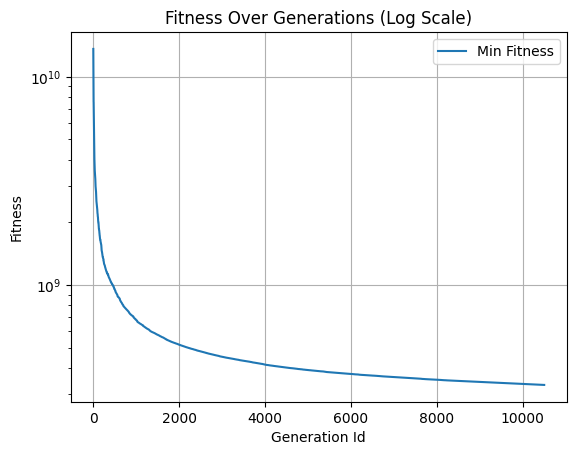

In [4]:
visualizer.draw_fitness_over_generations()

Funkcja celu bardzo szybko maleje w początkowej fazie ewolucji, co wskazuje
na duży potencjał poprawy na początku, a następnie staje się coraz bardziej płaska,
co sugeruje malejące korzyści z dodawania kolejnych trójkątów.

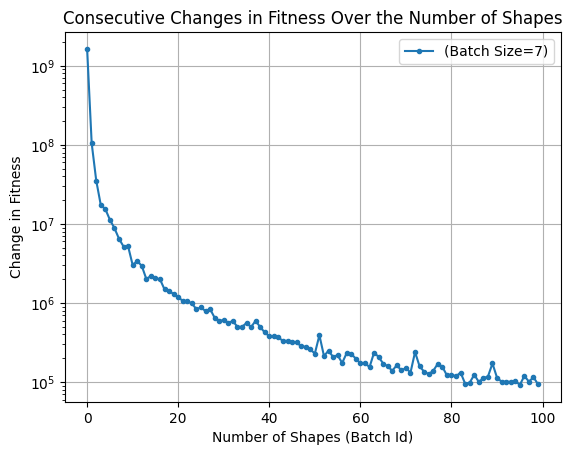

In [5]:
visualizer.draw_changes_of_fitness()

Rząd wielkości zysków z kolejnych trójkątów znacząco maleje z czasem, podczas gdy rząd wielkości
funkcji celu pozostaje niezmienny.

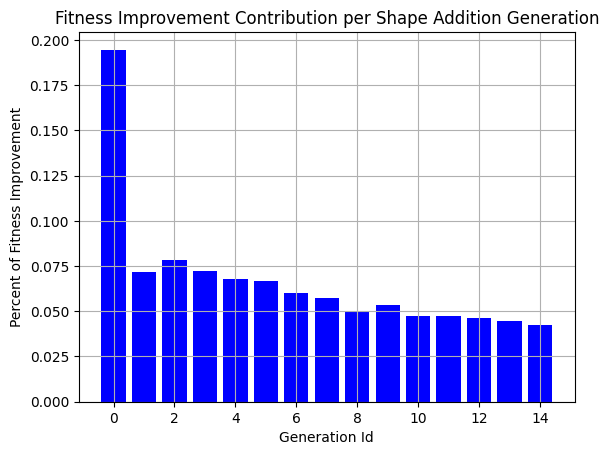

In [6]:
visualizer.draw_fitness_contribution()

Kontrybucje początkowych generacji przy dodawaniu nowego trójkąta są lekko
większe od końcowych. Niekoniecznie oznacza to, że opłacalne jest
zmniejszenie liczby iteracji, ponieważ praca z większą ilością trójkątów
mogłaby mieć negatywne skutki wydajnościowe.

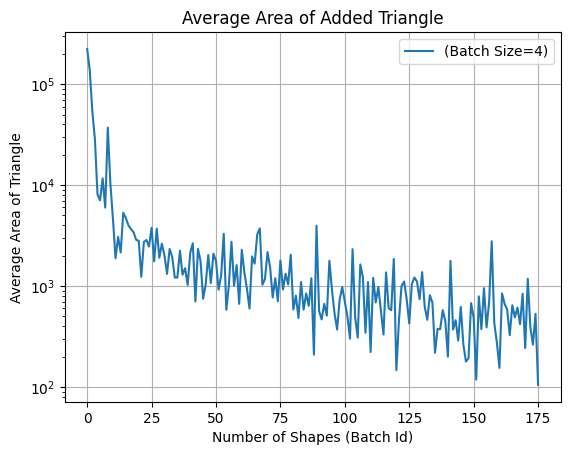

In [7]:
visualizer.draw_average_shape_area()

Pole trójkątów oscyluje w okolicach $10^3$ przez większość trwania ewolucji.

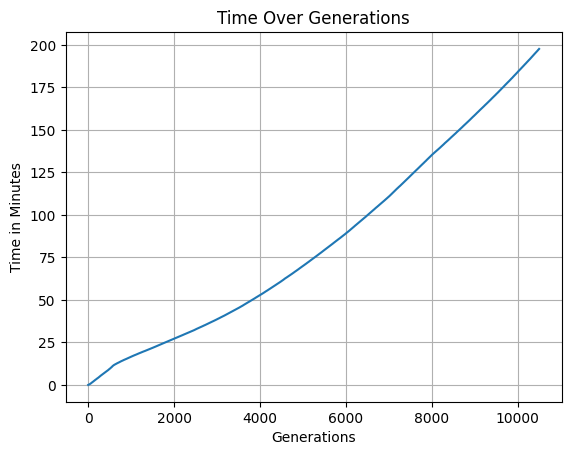

In [8]:
visualizer.draw_time_over_generations()

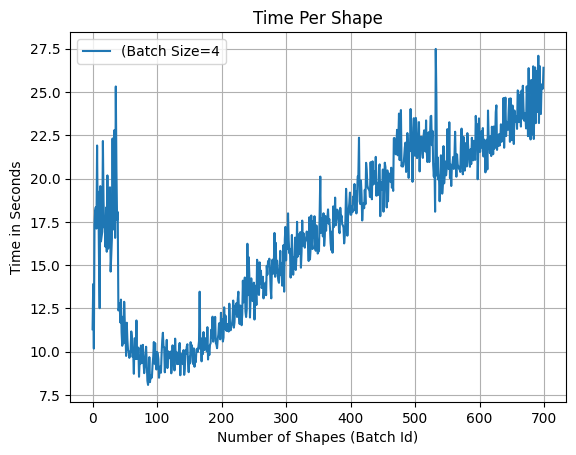

In [9]:
visualizer.draw_time_per_shape()

Na początku ewolucji czas obliczeń jest znacząco większy, ze wględu na szerokie
przeszukiwanie dużych trójkątów. Gdy rozmiar świeżo generowanych trójkątów spada,
widać znaczącą poprawę wydajności. Od tego miejsca funkcja czasu na jeden kształt
przypomina funkcję liniową, w której dołożenie $100$ trójkątów zwiększa czas o $2$ sekundy.

### Perspektywy Rozwoju

Obecnie wiele wartości, takich jak, zaburzenia losowe, liczba iteracji na kształt czy parametry
propabilistyczne, są ręcznie ustawione. Mogłyby to być parametry adaptujące
się do etapu w ewolucji, miejsca w obrazie oraz historii poprzednich ruchów.

Dodanie nowych kształtów mogłoby pozytywnie wpłynąć na jakość odzworowania szczegółów obrazu.

### Podsumowanie

Zaprojektowany algorytm ewolucyjny okazał się skuteczny w generowaniu rozwiązań
zbliżonych do oczekiwanego obrazu. Wykresy funkcji celu i analiza czasu obliczeń
dostarczają cennych informacji o działaniu algorytmu. Model potrafi dopasować
się do globalnych cech obrazu i dopracować szczegóły w późniejszej fazie.